<a href="https://colab.research.google.com/github/lukekolbe/AL-in-CreditScoring/blob/main/threshold_tuner.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Setup

In [ ]:
from google.colab import drive
drive.mount('/gdrive', force_remount=True)

Mounted at /gdrive


In [ ]:
############ LIBRARIES

!pip install scikit-plot


import os
import random
import multiprocessing
import pickle
import copy
import gc
import sys
import json
gc.enable()

import warnings
warnings.filterwarnings('ignore')


import numpy as np
import pandas as pd
pd.set_option('display.max_columns', None)
import matplotlib.pyplot as plt
import seaborn as sns
import scikitplot as skplt

from sklearn.preprocessing import RobustScaler


from sklearn.model_selection import train_test_split
from sklearn.model_selection import StratifiedKFold  ##### what is this used for?
from sklearn.model_selection import StratifiedShuffleSplit

from sklearn.linear_model import LogisticRegression

from sklearn.metrics import confusion_matrix
from sklearn.metrics import ConfusionMatrixDisplay


############ RANDOMNESS
# seed function
def seed_everything(seed):
    os.environ['PYTHONHASHSEED'] = str(seed)
    random.seed(seed)
    np.random.seed(seed)
    
# set seed
seed = 30
seed_everything(seed)


In [ ]:
os.chdir('/gdrive/My Drive/ACTIVE LEARNING THESIS/')

# Data Loader

In [ ]:
############ DATA IMPORT

## available datasets
# bene1         # some 

    # OK gmsc          # shape:  (150000, 68)
    # OK uk            # very low bad rate, shape:  (30000, 51), y mean:  0.04
    # OK lendingclub   # loooow performance, X shape:  (41623, 114) y shape:  (41623,) y mean:  0.1331235134420873    
    
    # OK bene2         # some learning, shape:  (7190, 28) >> 3 folds NO WASTE
    
    # bene1_nobins  # shape:  (3123, 18) # 5 folds NO WASTE
        # hmeq          # not promising either, shape:  (5960, 20) # 5 folds NO WASTE
        # australian    # very small dataset shape:  (690, 42) >> 10 folds NO WASTE
        # german        # shape:  (1000, 61) >> 10 folds NO WASTE
        # thomas        # loooow performance shape:  (1225, 28) >> 10 folds NO WASTE

# pakdd         # shape:  (50000, 373), y mean:  0.26082

data_name = "uk"
dataset_list = ["bene2", "bene1_nobins","gmsc", "uk", "lendingclub", "hmeq", "australian", "german", "thomas", "pakdd"]

def data_loader(dataset):

  #df = pd.read_csv('//home//RDC//kolbeluk1//AL_THESIS//prepared_data//{}.csv'.format(dataset)) #Linux path

  # C:\\Users\\kolbeluk1\\AL_THESIS
  #df = pd.read_csv('C:\\Users\\kolbeluk1\\AL_THESIS\\prepared_data\\{}.csv'.format(dataset))
  df = pd.read_csv('/gdrive/My Drive/ACTIVE LEARNING THESIS/prepared_data/{}.csv'.format(dataset))

  # remove NA
  df = df.dropna()
  df.reset_index(drop = True, inplace = True)

  #print(df)
  # extract label
  df['BAD'][df['BAD']=='BAD']  = 1
  df['BAD'][df['BAD']=='GOOD'] = 0
  df['BAD'] = df['BAD'].astype('int')


  y_temp = df['BAD']
  del df['BAD']

  #one hot encoding
  df = pd.get_dummies(df)

  #transform to numpy array >> same location for df and X
  X = df.to_numpy()
  y = y_temp.to_numpy()

  print("X type: ", type(X), "X shape: ",X.shape,"y shape: ", y.shape, "y mean: ", np.mean(y))
  #print (id(X), id(df))
  #print(y)

  return X,y


In [ ]:
'''if len(y) > 25000:
    validation_size = 7500
    folds = 3
    sss = StratifiedShuffleSplit(n_splits=1, test_size=validation_size, random_state=seed) #
    for model, validation in sss.split(X=X, y=y):
        model_idx, validation_idx = np.asarray(model), np.asarray(validation)

    print(np.sum(model_idx), np.sum(validation_idx))
    X_val, y_val = X[validation_idx,:], y[validation_idx]
    #X_model, y_model = X[model_idx,:], y[model_idx]

elif len(y) < 2000:
    folds = 10
    X_val, y_val = X, y

else:
    folds = 5
    X_val, y_val = X, y
    
print(np.shape(X), np.shape(X_val), 'folds: ', folds)'''

"if len(y) > 25000:\n    validation_size = 5000\n    folds = 3\n    sss = StratifiedShuffleSplit(n_splits=1, test_size=validation_size, random_state=seed) #\n    for model, validation in sss.split(X=X, y=y):\n        model_idx, validation_idx = np.asarray(model), np.asarray(validation)\n\n    print(np.sum(model_idx), np.sum(validation_idx))\n    X_val, y_val = X[validation_idx,:], y[validation_idx]\n    #X_model, y_model = X[model_idx,:], y[model_idx]\n\nelif len(y) < 2000:\n    folds = 10\n    X_val, y_val = X, y\n\nelse:\n    folds = 5\n    X_val, y_val = X, y\n    \nprint(np.shape(X), np.shape(X_val), 'folds: ', folds)"

# Helper Functions

In [ ]:
# append_record: helper function that adds best-parameter for every model to dict and saves it
def append_record(record, filename):
    with open(f'{filename}', 'a') as f:
        json.dump(record, f)
        f.write(os.linesep)

In [ ]:
# loader function that unpacks tuning results and extracts parameters for different model steps
def param_getter(tuned=False, dataset=None):
  filename = f'{dataset}_tuned-params'

  with open(filename, 'r') as f:
    param_list = [json.loads(line) for line in f if line.startswith('{')]

  param_dict = {}
  for i in range(len(param_list)):
    strategy_short = list(param_list[i].keys())[0]
    param_dict[strategy_short] = param_list[i][list(param_list[i].keys())[0]]

  #find cases where some models are not tuned, establish base parameters
  for key, name in [('oracle', 'Oracle'),
                    ('score', 'Score'),
                    ('eer', 'QueryExpectedErrorReduction'), 
                    ('quire', 'QueryInstanceQUIRE'), 
                    ('bmdr','QueryInstanceBMDR'),
                    ('spal', 'QueryInstanceSPAL')]:
    try:
      param_dict[key]
    except KeyError:
      param_dict[key] = {'AL':{'strategy_name':name}, 'CLF':{}}

  # transfer tuned classifier to all models (clf is tuned separately, not in combination with AL model)
  for key in param_dict.keys():
    param_dict[key]['CLF']=param_dict['random']['CLF']

  for key in ['bmdr', 'spal']:
    param_dict[key]['AL']['rho'] = 10 #set this parameter for increased performance
  
  return param_dict

In [ ]:
'''
  applies every threshold to a given prediction vector and returns misclassification cost as defined in the cost matrix
'''

def cost_tuner(y, pred_raw, y_mean, thres_array, cost_matrix = None):
  if cost_matrix == None:
    fn_cost = (1-y_mean)/y_mean # set fn cost to the inverse of the probability of the rare class; fix cost of fp to 1
    cost_matrix = [[0, 1],[fn_cost, 0]]

  print(cost_matrix)

  cost_list = []
  for t in thres_array:
    pred_thres =  (pred_raw[:,1] >= t).astype(int)
    if thres_array.index(t)%100 == 0:
      print(f'from cost tuner: confusion mat for threshold {t}:',confusion_matrix(y, pred_thres).ravel())
      print(f'from cost tuner: cost for threshold {t}:',np.array([confusion_matrix(y, pred_thres)* cost_matrix]).ravel())
    cost = np.sum(confusion_matrix(y, pred_thres) * cost_matrix)
    cost_list.append(cost)

  print(cost_list)
  cost_min_fold = min(cost_list)
  print('cost_min_fold', cost_min_fold)
  cost_min_fold_index = cost_list.index(cost_min_fold)
  print('cost_min_fold_index', cost_min_fold_index)
  best_threshold_fold = thres_array[cost_min_fold_index]
  print(f'from cost tuner: best threshold of this fold: {best_threshold_fold}; minimum cost: {cost_min_fold}')

  return cost_list

In [ ]:
'''
  the pipeline that loads pre-tuned classifier parameters, processes data (scaling, splitting), 
  trains the tuned classifier, makes a prediction, 
  computes cost for all thresholds, picks threshold that minimizes cost
'''

def threshold_finder(X,y,dataset,folds,cost_matrix):
  seed_everything(seed)

  param_dict = param_getter(tuned=True, dataset=dataset) # load tuned parameters
  clf = LogisticRegression(random_state = seed,**param_dict['random']['CLF']) #set up tuned classifier
  
  skf = StratifiedKFold(n_splits=folds, shuffle = True, random_state=seed)
  idx = []
  for train_index, test_index in skf.split(X, y):
    idx.append((train_index, test_index))

  cost_list = []
  thres_arr =  [np.round(i, 3) for i in iter(np.linspace(0, 1, 1001))] # 1000 possible thresholds between 0 and 1

  y_mean = np.mean(y)


  for f in range(folds-1):
    if len(y)<2000:
      train_idx = idx[f][0]
      test_idx = idx[f][1]
    else:
      #for large datasets, swap order of train and test indices in order to not train on too much data and closer reflect the conditions within the experiment
      train_idx = idx[f][1]
      test_idx = idx[f][0]
    
    if f == 0:
      print('lenghts of train & test: ',len(train_idx), len(test_idx))


    scaler = RobustScaler(with_centering=True, with_scaling=True)
    scaler.fit(X[train_idx,:])
    X_t = scaler.transform(np.array(X)) #scaled version of full dataset 

    clf.fit(X_t[train_idx,:], y[train_idx])
    probabilities = clf.predict_proba(X_t[test_idx,:])

    # for each threshold, compute the misclassification cost and add it to the list
    cost_list.append(cost_tuner(y[test_idx], probabilities, y_mean, thres_arr, cost_matrix = cost_matrix))

    print(np.shape(cost_list))
  
  #compute mean cost for each threshold across training folds
  mean_cost = np.mean(cost_list, axis = 0)
  print(mean_cost)
  cost_min = min(mean_cost)
  cost_min_index = np.where(mean_cost == mean_cost.min())[0][0]
  best_thres = np.round(thres_arr[cost_min_index], 3)

  return best_thres



# Run for all datasets in one go

In [ ]:
threshold_dict = {}
folds = 5
#cost_matrices = [None, [[0,1],[2,0]], [[0,1],[5,0]], [[0,1],[10,0]]]
cost_matrices = [None] #other cost matrices not feasible


for cost_matrix in cost_matrices:
  for d in dataset_list:
    X,y = data_loader(d)

    filename = 'tuned_thresholds'
    
    if cost_matrix != None:
      filename += f"_cost-{cost_matrix[0][1]}-{cost_matrix[1][0]}"

    cost_threshold = threshold_finder(X, y, d, folds, cost_matrix = cost_matrix, params=param_dict['random']['CLF'])
    print(f'for dataset {d}, and cost matrix {cost_matrix}, best threshold is {cost_threshold}')
    print("---------------------------------------------")

    threshold_dict[f'{d}'] = copy.deepcopy(cost_threshold)

  print(threshold_dict)

  with open(f'{filename}', 'wb') as a_file:
    pickle.dump(threshold_dict, a_file)

  a_file.close()

X type:  <class 'numpy.ndarray'> X shape:  (7190, 28) y shape:  (7190,) y mean:  0.3
lenghts of train & test:  1438 5752
[[0, 1], [2.3333333333333335, 0]]
from cost tuner: confusion mat for threshold 0.0: [   0 4027    0 1725]
from cost tuner: cost for threshold 0.0: [   0. 4027.    0.    0.]
from cost tuner: confusion mat for threshold 0.1: [ 858 3169   33 1692]
from cost tuner: cost for threshold 0.1: [   0. 3169.   77.    0.]
from cost tuner: confusion mat for threshold 0.2: [1661 2366  129 1596]
from cost tuner: cost for threshold 0.2: [   0. 2366.  301.    0.]
from cost tuner: confusion mat for threshold 0.3: [2441 1586  359 1366]
from cost tuner: cost for threshold 0.3: [   0.         1586.          837.66666667    0.        ]
from cost tuner: confusion mat for threshold 0.4: [3117  910  684 1041]
from cost tuner: cost for threshold 0.4: [   0.  910. 1596.    0.]
from cost tuner: confusion mat for threshold 0.5: [3598  429 1116  609]
from cost tuner: cost for threshold 0.5: [   0

In [ ]:
{'bene2': 0.283, 'bene1_nobins': 0.372, 'gmsc': 0.057, 'uk': 0.039, 'lendingclub': 0.137, 'hmeq': 0.208, 'australian': 0.523, 'german': 0.307, 'thomas': 0.31, 'pakdd': 0.244}
#stored
{'bene2': 0.283, 'bene1_nobins': 0.372, 'gmsc': 0.057, 'uk': 0.039, 'lendingclub': 0.136, 'hmeq': 0.208, 'australian': 0.333, 'german': 0.336, 'thomas': 0.357, 'pakdd': 0.244}


{'bene2': 0.337, 'bene1_nobins': 0.372, 'gmsc': 0.335, 'uk': 0.442, 'lendingclub': 0.383, 'hmeq': 0.317, 'australian': 0.39, 'german': 0.307, 'thomas': 0.382, 'pakdd': 0.337}
#stored
{'bene2': 0.337, 'bene1_nobins': 0.372, 'gmsc': 0.334, 'uk': 0.443, 'lendingclub': 0.381, 'hmeq': 0.317, 'australian': 0.331, 'german': 0.336, 'thomas': 0.382, 'pakdd': 0.337}


{'bene2': 0.22, 'bene1_nobins': 0.245, 'gmsc': 0.156, 'uk': 0.168, 'lendingclub': 0.173, 'hmeq': 0.18, 'australian': 0.129, 'german': 0.169, 'thomas': 0.145, 'pakdd': 0.175}
#stored
{'bene2': 0.22, 'bene1_nobins': 0.246, 'gmsc': 0.173, 'uk': 0.169, 'lendingclub': 0.173, 'hmeq': 0.18, 'australian': 0.221, 'german': 0.208, 'thomas': 0.042, 'pakdd': 0.175}


{'bene2': 0.148, 'bene1_nobins': 0.164, 'gmsc': 0.072, 'uk': 0.092, 'lendingclub': 0.093, 'hmeq': 0.119, 'australian': 0.129, 'german': 0.101, 'thomas': 0.088, 'pakdd': 0.09}
#stored
{'bene2': 0.149, 'bene1_nobins': 0.164, 'gmsc': 0.072, 'uk': 0.092, 'lendingclub': 0.093, 'hmeq': 0.119, 'australian': 0.207, 'german': 0.147, 'thomas': 0.03, 'pakdd': 0.09}



In [ ]:
##NONE
#current code
{'bene2': 0.283, 'bene1_nobins': 0.372, 'gmsc': 0.057, 'uk': 0.039, 'lendingclub': 0.136, 'hmeq': 0.208, 'australian': 0.333, 'german': 0.336, 'thomas': 0.357, 'pakdd': 0.244}
{'bene2': 0.282, 'bene1_nobins': 0.389, 'gmsc': 0.057, 'uk': 0.039, 'lendingclub': 0.135, 'hmeq': 0.208, 'australian': 0.523, 'german': 0.307, 'thomas': 0.31, 'pakdd': 0.244}
{'bene2': 0.282, 'bene1_nobins': 0.389, 'gmsc': 0.057, 'uk': 0.039, 'lendingclub': 0.135, 'hmeq': 0.208, 'australian': 0.523, 'german': 0.307, 'thomas': 0.31, 'pakdd': 0.244}
#seed in clf
{'bene2': 0.283, 'bene1_nobins': 0.372, 'gmsc': 0.057, 'uk': 0.039, 'lendingclub': 0.137, 'hmeq': 0.208, 'australian': 0.523, 'german': 0.307, 'thomas': 0.31, 'pakdd': 0.244}
{'bene2': 0.283, 'bene1_nobins': 0.372, 'gmsc': 0.057, 'uk': 0.039, 'lendingclub': 0.137, 'hmeq': 0.208, 'australian': 0.523, 'german': 0.307, 'thomas': 0.31, 'pakdd': 0.244}

#legacy code
{'bene2': 0.282, 'bene1_nobins': 0.389, 'gmsc': 0.057, 'uk': 0.039, 'lendingclub': 0.136, 'hmeq': 0.208, 'australian': 0.333, 'german': 0.336, 'thomas': 0.357, 'pakdd': 0.244}
#with seed
{'bene2': 0.283, 'bene1_nobins': 0.372, 'gmsc': 0.057, 'uk': 0.039, 'lendingclub': 0.137, 'hmeq': 0.208, 'australian': 0.333, 'german': 0.336, 'thomas': 0.357, 'pakdd': 0.244}

#stored
{'bene2': 0.283, 'bene1_nobins': 0.372, 'gmsc': 0.057, 'uk': 0.039, 'lendingclub': 0.136, 'hmeq': 0.208, 'australian': 0.333, 'german': 0.336, 'thomas': 0.357, 'pakdd': 0.244}



##1-2
#current code
{'bene2': 0.337, 'bene1_nobins': 0.389, 'gmsc': 0.334, 'uk': 0.444, 'lendingclub': 0.385, 'hmeq': 0.317, 'australian': 0.39, 'german': 0.307, 'thomas': 0.382, 'pakdd': 0.337}
#seed
{'bene2': 0.337, 'bene1_nobins': 0.372, 'gmsc': 0.335, 'uk': 0.442, 'lendingclub': 0.383, 'hmeq': 0.317, 'australian': 0.39, 'german': 0.307, 'thomas': 0.382, 'pakdd': 0.337}

#legacy code
{'bene2': 0.337, 'bene1_nobins': 0.389, 'gmsc': 0.335, 'uk': 0.441, 'lendingclub': 0.384, 'hmeq': 0.317, 'australian': 0.331, 'german': 0.336, 'thomas': 0.382, 'pakdd': 0.337}
#with seed
{'bene2': 0.337, 'bene1_nobins': 0.372, 'gmsc': 0.335, 'uk': 0.442, 'lendingclub': 0.383, 'hmeq': 0.317, 'australian': 0.331, 'german': 0.336, 'thomas': 0.382, 'pakdd': 0.337}


#stored
{'bene2': 0.337, 'bene1_nobins': 0.372, 'gmsc': 0.334, 'uk': 0.443, 'lendingclub': 0.381, 'hmeq': 0.317, 'australian': 0.331, 'german': 0.336, 'thomas': 0.382, 'pakdd': 0.337}



##1-5
#current code
{'bene2': 0.22, 'bene1_nobins': 0.244, 'gmsc': 0.157, 'uk': 0.168, 'lendingclub': 0.17, 'hmeq': 0.18, 'australian': 0.129, 'german': 0.169, 'thomas': 0.145, 'pakdd': 0.175}
#seed
{'bene2': 0.22, 'bene1_nobins': 0.245, 'gmsc': 0.156, 'uk': 0.168, 'lendingclub': 0.173, 'hmeq': 0.18, 'australian': 0.129, 'german': 0.169, 'thomas': 0.145, 'pakdd': 0.175}


#legacy code
{'bene2': 0.22, 'bene1_nobins': 0.245, 'gmsc': 0.16, 'uk': 0.169, 'lendingclub': 0.173, 'hmeq': 0.18, 'australian': 0.221, 'german': 0.208, 'thomas': 0.042, 'pakdd': 0.175}
#with seed
{'bene2': 0.22, 'bene1_nobins': 0.245, 'gmsc': 0.156, 'uk': 0.168, 'lendingclub': 0.173, 'hmeq': 0.18, 'australian': 0.221, 'german': 0.208, 'thomas': 0.042, 'pakdd': 0.175}


#stored
{'bene2': 0.22, 'bene1_nobins': 0.246, 'gmsc': 0.173, 'uk': 0.169, 'lendingclub': 0.173, 'hmeq': 0.18, 'australian': 0.221, 'german': 0.208, 'thomas': 0.042, 'pakdd': 0.175}



##1-10
#current code
{'bene2': 0.149, 'bene1_nobins': 0.164, 'gmsc': 0.072, 'uk': 0.092, 'lendingclub': 0.096, 'hmeq': 0.119, 'australian': 0.113, 'german': 0.101, 'thomas': 0.088, 'pakdd': 0.09}
{'bene2': 0.149, 'bene1_nobins': 0.164, 'gmsc': 0.072, 'uk': 0.092, 'lendingclub': 0.096, 'hmeq': 0.119, 'australian': 0.129, 'german': 0.101, 'thomas': 0.088, 'pakdd': 0.09}
{'bene2': 0.148, 'bene1_nobins': 0.164, 'gmsc': 0.072, 'uk': 0.092, 'lendingclub': 0.094, 'hmeq': 0.119, 'australian': 0.129, 'german': 0.101, 'thomas': 0.088, 'pakdd': 0.09}
#seed
{'bene2': 0.148, 'bene1_nobins': 0.164, 'gmsc': 0.072, 'uk': 0.092, 'lendingclub': 0.093, 'hmeq': 0.119, 'australian': 0.129, 'german': 0.101, 'thomas': 0.088, 'pakdd': 0.09}


#legacy code
{'bene2': 0.148, 'bene1_nobins': 0.164, 'gmsc': 0.071, 'uk': 0.092, 'lendingclub': 0.096, 'hmeq': 0.119, 'australian': 0.207, 'german': 0.147, 'thomas': 0.03, 'pakdd': 0.09}
#with seed
{'bene2': 0.148, 'bene1_nobins': 0.164, 'gmsc': 0.072, 'uk': 0.092, 'lendingclub': 0.093, 'hmeq': 0.119, 'australian': 0.207, 'german': 0.147, 'thomas': 0.03, 'pakdd': 0.09}


#stored
{'bene2': 0.149, 'bene1_nobins': 0.164, 'gmsc': 0.072, 'uk': 0.092, 'lendingclub': 0.093, 'hmeq': 0.119, 'australian': 0.207, 'german': 0.147, 'thomas': 0.03, 'pakdd': 0.09}


In [ ]:
fname = "tuned_thresholds_cost-1-10"
infile = open(f'{fname}','rb')
tuned_thresholds_1_10 = pickle.load(infile)
infile.close()

tuned_thresholds_1_10
print(tuned_thresholds_1_10)


{'bene2': 0.149, 'bene1_nobins': 0.164, 'gmsc': 0.072, 'uk': 0.092, 'lendingclub': 0.093, 'hmeq': 0.119, 'australian': 0.207, 'german': 0.147, 'thomas': 0.03, 'pakdd': 0.09}


In [ ]:
fname = "tuned_thresholds_cost-1-5"
infile = open(f'{fname}','rb')
tuned_thresholds_1_5 = pickle.load(infile)
infile.close()

print(tuned_thresholds_1_5)

{'bene2': 0.22, 'bene1_nobins': 0.246, 'gmsc': 0.173, 'uk': 0.169, 'lendingclub': 0.173, 'hmeq': 0.18, 'australian': 0.221, 'german': 0.208, 'thomas': 0.042, 'pakdd': 0.175}


In [ ]:
fname = "tuned_thresholds_cost-1-2"
infile = open(f'{fname}','rb')
tuned_thresholds_1_2 = pickle.load(infile)
infile.close()

print(tuned_thresholds_1_2)

{'bene2': 0.337, 'bene1_nobins': 0.372, 'gmsc': 0.334, 'uk': 0.443, 'lendingclub': 0.381, 'hmeq': 0.317, 'australian': 0.331, 'german': 0.336, 'thomas': 0.382, 'pakdd': 0.337}


In [ ]:
fname = "tuned_thresholds_new"
infile = open(f'{fname}','rb')
tuned_thresholds_none = pickle.load(infile)
infile.close()

print(tuned_thresholds_none)

{'bene2': 0.283, 'bene1_nobins': 0.372, 'gmsc': 0.057, 'uk': 0.039, 'lendingclub': 0.136, 'hmeq': 0.208, 'australian': 0.333, 'german': 0.336, 'thomas': 0.357, 'pakdd': 0.244}


# RUN FOR SINGLE DATASET

In [ ]:
data_name = "australian" #lendingclub, german, australian

X,y = data_loader(data_name)

#scaler = RobustScaler(with_centering=True, with_scaling=True)
#scaler.fit(X)
#X = scaler.transform(np.array(X)) #scaled version of full dataset

#filename = f'{data_name}_threshold'


X type:  <class 'numpy.ndarray'> X shape:  (690, 42) y shape:  (690,) y mean:  0.4449275362318841


In [ ]:
param_dict = param_getter(tuned=True, dataset = data_name) # load tuned parameters
clf = LogisticRegression(**param_dict['random']['CLF'])
#clf=LogisticRegression(solver = 'lbfgs', penalty='none')
print(clf)

LogisticRegression(C=0.1, max_iter=50, penalty='l1', solver='liblinear',
                   tol=0.001)


In [ ]:
threshold_dict = {}
folds = 5
cost_matrix = None
# [[0,1],[2,0]] # [[0,1],[5,0]] # [[0,1],[10,0]] # [[-2,1],[5,-0.5]] 

filename = 'TEST_tuned_thresholds'
try:
  filename += f"_cost-{cost_matrix[0][1]}-{cost_matrix[1][0]}"
except TypeError:
  filename += f"_cost-None"

for d in ['australian']:
  X,y = data_loader(d)

  cost_threshold = threshold_finder(X, y, d, folds, cost_matrix = cost_matrix)
  print(f'for dataset {d}, best threshold is {cost_threshold}')
  print("---------------------------------------------")

  threshold_dict[f'{d}'] = copy.deepcopy(cost_threshold)

for k in threshold_dict.keys():
  print(threshold_dict[k])


X type:  <class 'numpy.ndarray'> X shape:  (690, 42) y shape:  (690,) y mean:  0.4449275362318841
lenghts of train & test:  552 138
[[0, 1], [1.2475570032573289, 0]]
from cost tuner: confusion mat for threshold 0.0: [ 0 77  0 61]
from cost tuner: cost for threshold 0.0: [ 0. 77.  0.  0.]
from cost tuner: confusion mat for threshold 0.1: [44 33  0 61]
from cost tuner: cost for threshold 0.1: [ 0. 33.  0.  0.]
from cost tuner: confusion mat for threshold 0.2: [58 19  0 61]
from cost tuner: cost for threshold 0.2: [ 0. 19.  0.  0.]
from cost tuner: confusion mat for threshold 0.3: [61 16  0 61]
from cost tuner: cost for threshold 0.3: [ 0. 16.  0.  0.]
from cost tuner: confusion mat for threshold 0.4: [63 14  0 61]
from cost tuner: cost for threshold 0.4: [ 0. 14.  0.  0.]
from cost tuner: confusion mat for threshold 0.5: [68  9  4 57]
from cost tuner: cost for threshold 0.5: [0.         9.         4.99022801 0.        ]
from cost tuner: confusion mat for threshold 0.6: [72  5 10 51]
from

(5, 2)
y mean of whole data:  0.1331235134420873
DEFAULT FN cost:  6.511820970943873
no. of training samples:  8325
lenghts of train & test:  8325 33298
mean of prediction:  0.13390181030766568
median of prediction:  0.128653321623204


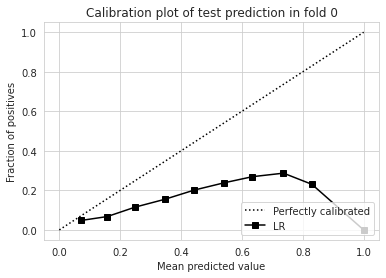

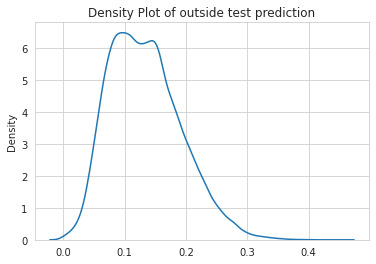

from cost tuner: confusion mat for threshold 0.0: [    0 28865     0  4433]
from cost tuner: confusion mat for threshold 0.01: [   59 28806     5  4428]
from cost tuner: confusion mat for threshold 0.02: [  165 28700     7  4426]
from cost tuner: confusion mat for threshold 0.03: [  350 28515    16  4417]
from cost tuner: confusion mat for threshold 0.04: [  732 28133    42  4391]
from cost tuner: confusion mat for threshold 0.05: [ 1475 27390    73  4360]
from cost tuner: confusion mat for threshold 0.06: [ 2607 26258   144  4289]
from cost tuner: confusion mat for threshold 0.07: [ 4158 24707   238  4195]
from cost tuner: confusion mat for threshold 0.08: [ 6002 22863   352  4081]
from cost tuner: confusion mat for threshold 0.09: [ 7959 20906   549  3884]
from cost tuner: confusion mat for threshold 0.1: [ 9910 18955   765  3668]
from cost tuner: confusion mat for threshold 0.11: [11808 17057   991  3442]
from cost tuner: confusion mat for threshold 0.12: [13677 15188  1231  3202]
f

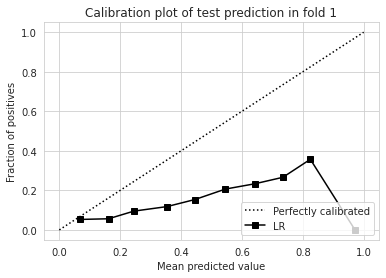

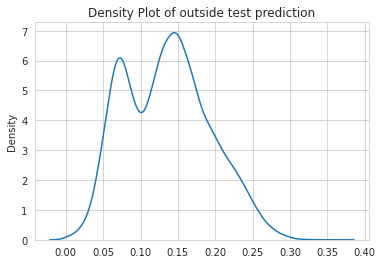

from cost tuner: confusion mat for threshold 0.0: [    0 28865     0  4433]
from cost tuner: confusion mat for threshold 0.01: [   53 28812     3  4430]
from cost tuner: confusion mat for threshold 0.02: [  137 28728     4  4429]
from cost tuner: confusion mat for threshold 0.03: [  316 28549    16  4417]
from cost tuner: confusion mat for threshold 0.04: [  702 28163    40  4393]
from cost tuner: confusion mat for threshold 0.05: [ 1548 27317    86  4347]
from cost tuner: confusion mat for threshold 0.06: [ 2926 25939   149  4284]
from cost tuner: confusion mat for threshold 0.07: [ 4798 24067   270  4163]
from cost tuner: confusion mat for threshold 0.08: [ 6731 22134   437  3996]
from cost tuner: confusion mat for threshold 0.09: [ 8311 20554   596  3837]
from cost tuner: confusion mat for threshold 0.1: [ 9582 19283   751  3682]
from cost tuner: confusion mat for threshold 0.11: [10786 18079   891  3542]
from cost tuner: confusion mat for threshold 0.12: [12334 16531  1050  3383]
f

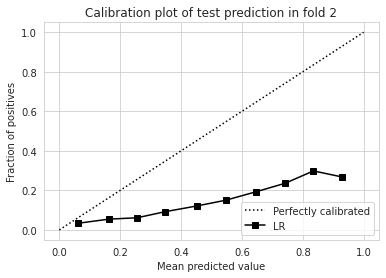

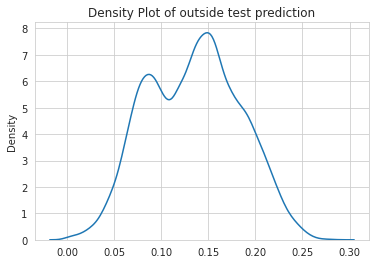

from cost tuner: confusion mat for threshold 0.0: [    0 28866     0  4432]
from cost tuner: confusion mat for threshold 0.01: [   54 28812     3  4429]
from cost tuner: confusion mat for threshold 0.02: [  133 28733     3  4429]
from cost tuner: confusion mat for threshold 0.03: [  291 28575    10  4422]
from cost tuner: confusion mat for threshold 0.04: [  550 28316    28  4404]
from cost tuner: confusion mat for threshold 0.05: [ 1067 27799    62  4370]
from cost tuner: confusion mat for threshold 0.06: [ 1888 26978   100  4332]
from cost tuner: confusion mat for threshold 0.07: [ 3220 25646   187  4245]
from cost tuner: confusion mat for threshold 0.08: [ 5034 23832   309  4123]
from cost tuner: confusion mat for threshold 0.09: [ 6996 21870   456  3976]
from cost tuner: confusion mat for threshold 0.1: [ 8863 20003   629  3803]
from cost tuner: confusion mat for threshold 0.11: [10450 18416   799  3633]
from cost tuner: confusion mat for threshold 0.12: [12061 16805  1005  3427]
f

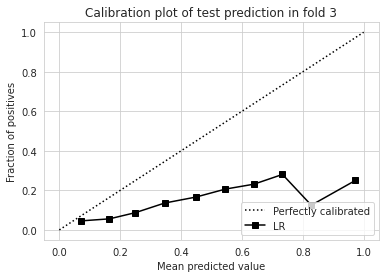

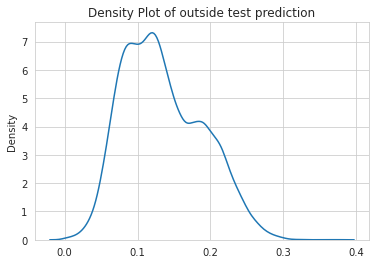

from cost tuner: confusion mat for threshold 0.0: [    0 28866     0  4433]
from cost tuner: confusion mat for threshold 0.01: [   34 28832     0  4433]
from cost tuner: confusion mat for threshold 0.02: [   80 28786     6  4427]
from cost tuner: confusion mat for threshold 0.03: [  190 28676     9  4424]
from cost tuner: confusion mat for threshold 0.04: [  413 28453    23  4410]
from cost tuner: confusion mat for threshold 0.05: [  896 27970    48  4385]
from cost tuner: confusion mat for threshold 0.06: [ 1840 27026    99  4334]
from cost tuner: confusion mat for threshold 0.07: [ 3315 25551   180  4253]
from cost tuner: confusion mat for threshold 0.08: [ 5208 23658   323  4110]
from cost tuner: confusion mat for threshold 0.09: [ 7355 21511   510  3923]
from cost tuner: confusion mat for threshold 0.1: [ 9469 19397   711  3722]
from cost tuner: confusion mat for threshold 0.11: [11514 17352   937  3496]
from cost tuner: confusion mat for threshold 0.12: [13688 15178  1201  3232]
f

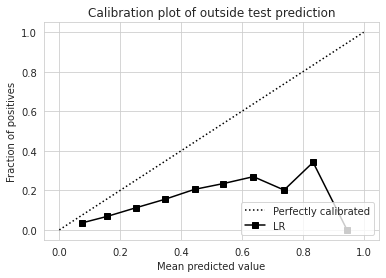

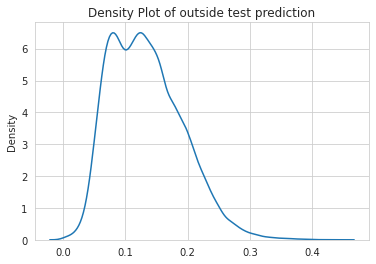

mean of thresholded prediction:  0.421333973993213
[0.16174308 0.14656868 0.2593587  0.17456853 0.14378345 0.13553111
 0.16404902 0.08992815 0.13273959 0.0279008  0.12079459 0.11934382
 0.21240781 0.15574599 0.22059003 0.11227459 0.198555   0.12279171
 0.20850751 0.11154488]
[1 1 1 1 1 0 1 0 0 0 0 0 1 1 1]
percentage kept:  0.5786660260067871
[[17485 11381]
 [ 1784  2649]]


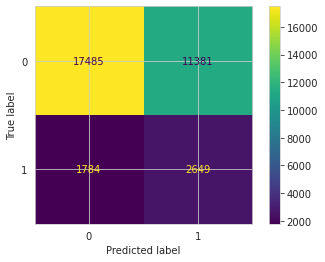

In [ ]:
#manual run

folds = 5

#cost_matrix = [[-4,1],[16,-2]] #tn, fp, fn, tp
cost_matrix=None

# SPLIT DATA
skf = StratifiedKFold(n_splits=folds, shuffle = True, random_state=seed)
idx = []
for train_index, test_index in skf.split(X, y):
  idx.append((train_index, test_index))

print(np.shape(idx))
cost_list = []
thres_arr =  [np.round(i,3) for i in iter(np.linspace(0, 1, 101))]
#print(thres_arr)


y_mean = np.mean(y)
print(f'y mean of whole data: ', y_mean)
print('DEFAULT FN cost: ',(1-y_mean)/y_mean)

print('no. of training samples: ',len(idx[0][1]))

for f in range(folds-1):
  train_idx = idx[f][1] #swap order: use many small training sets and large test sets >> closer to conditions in experiment, where small samples are used...
  test_idx = idx[f][0]
  #print(len(train_idx))
  print('lenghts of train & test: ',len(train_idx), len(test_idx))

  scaler = RobustScaler(with_centering=True, with_scaling=True)
  scaler.fit(X[train_idx,:])
  X_t = scaler.transform(np.array(X)) #scaled version of full dataset

  clf.fit(X_t[train_idx,:], y[train_idx])
  probabilities = clf.predict_proba(X_t[test_idx,:])

  print('mean of prediction: ', np.mean(probabilities[:,1]))
  print('median of prediction: ', np.median(probabilities[:,1]))

  '''y_mean = np.mean(y[train_idx])
  print(f'y mean of fold {f}: ', y_mean)
  print('FN cost (if computed): ',(1-y_mean)/y_mean)'''

  skplt.metrics.plot_calibration_curve(y[test_idx],[probabilities], ['LR'], title = f'Calibration plot of test prediction in fold {f}')
  plt.show()

  sns.set_style('whitegrid')
  sns.kdeplot(probabilities[:,1]).set_title('Density Plot of outside test prediction')
  plt.show()

  cost_list.append(cost_tuner(y[test_idx], probabilities, y_mean, thres_arr, cost_matrix=cost_matrix))

  print("############## END OF LOOP ################")

print(cost_list)
#print('len cost list ', len(cost_list))

mean_cost = np.mean(cost_list, axis = 0)
print('mean cost: ', mean_cost)

cost_min = min(mean_cost)
print('minimum cost: ', cost_min)
cost_min_index = np.where(mean_cost == mean_cost.min())[0][0]

best_thres = thres_arr[cost_min_index]
print("best threshold: ",best_thres)


train_idx = idx[folds-1][1] #swap order: use many small training sets and large test sets >> closer to conditions in experiment, where small samples are used...
test_idx = idx[folds-1][0]
clf.fit(X[train_idx,:], y[train_idx])
probabilities = clf.predict_proba(X[test_idx,:])
print('mean of prediction: ', np.mean(probabilities[:,1]))
print('median of prediction: ', np.median(probabilities[:,1]))

skplt.metrics.plot_calibration_curve(y[test_idx],[probabilities], ['LR'], title = 'Calibration plot of outside test prediction')
plt.show()

sns.set_style('whitegrid')
sns.kdeplot(probabilities[:,1]).set_title('Density Plot of outside test prediction')
plt.show()
    

pred_thres = (probabilities[:,1] >= best_thres).astype(int)
#pred_thres = (probabilities[:,1] >= 0.5).astype(int)
print('mean of thresholded prediction: ', np.mean(pred_thres))
print(probabilities[:20,1])
print(pred_thres[:15])
print('percentage kept: ',1-np.mean(pred_thres))

disp = ConfusionMatrixDisplay.from_predictions(
    y[test_idx],
    pred_thres,
)
print(disp.confusion_matrix)

plt.show()




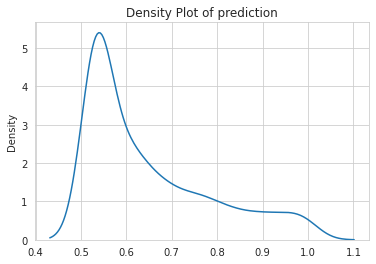

In [ ]:
sns.set_style('whitegrid')
sns.kdeplot(probabilities[:,0]).set_title('Density Plot of prediction')
plt.show()

# load tuned thresholds

In [ ]:
# 10-fold large idx
infile = open(f'{filename}','rb')
tuned_thresholds = pickle.load(infile)
infile.close()

tuned_thresholds

{'australian': 0.465,
 'bene1_nobins': 0.362,
 'bene2': 0.288,
 'german': 0.301,
 'gmsc': 0.059,
 'hmeq': 0.185,
 'lendingclub': 0.132,
 'pakdd': 0.238,
 'thomas': 0.281,
 'uk': 0.04}

In [ ]:
# 10-fold small idx
infile = open(f'{filename}','rb')
tuned_thresholds = pickle.load(infile)
infile.close()

tuned_thresholds

{'australian': 0.439,
 'bene1_nobins': 0.374,
 'bene2': 0.33,
 'german': 0.324,
 'gmsc': 0.059,
 'hmeq': 0.21,
 'lendingclub': 0.14,
 'pakdd': 0.25,
 'thomas': 0.377,
 'uk': 0.039}

In [ ]:
# 5-fold small idx
cost_matrix = [[0,1],[10,0]]
# [[0,1],[2,0]] # [[0,1],[5,0]] # [[0,1],[10,0]] # [[-2,1],[5,-0.5]] 

filename = 'tuned_thresholds'
filename += f"_cost-{cost_matrix[0][1]}-{cost_matrix[1][0]}"

infile = open(f'{filename}','rb')
tuned_thresholds = pickle.load(infile)
infile.close()

tuned_thresholds

{'australian': 0.333,
 'bene1_nobins': 0.372,
 'bene2': 0.282,
 'german': 0.336,
 'gmsc': 0.057,
 'hmeq': 0.208,
 'lendingclub': 0.136,
 'pakdd': 0.244,
 'thomas': 0.357,
 'uk': 0.039}